# Results
All graphs and results. For discussion please read associated paper.

In [1]:
# Imports for the rest of the notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from discrete_skip_gram.util import stats_string, calc_stats
from tabulate import tabulate
def load_output(path):
    return np.load('../experiments/output/{}'.format(path))
def table(t, **kwargs):
    return HTML(tabulate(t, tablefmt='html', **kwargs))
def bar(x, data, label=None, axis=1):
    mean = np.mean(data, axis=axis)
    std = np.std(data, axis=axis)
    plt.errorbar(x, mean, yerr=std, capsize=4,
                 markersize=3, fmt='-o', label=label)
def data_shapes(x):
    return {k:v.shape for k,v in x.iteritems()}
def stats_table(x, y, label, unit, axis=1):
    data = np.stack([x]+calc_stats(y, axis=axis)[0:4], axis=1)
    return table(data, headers=[label,
                                'Mean {}'.format(unit),
                                'Std','Min','Max'])
eps = 1e-9

## Cooccurrence matrix

Import precalculated cooccurrence matrix generated from Brown corpus.

Calculate marginal and conditional entropy.

In [2]:
# Load and normalize cooccurrence matrix
coo = load_output('cooccurrence.npy').astype(np.float32)
p = coo / np.sum(coo, axis=None)
print('Shape of cooccurrence matrix is {}'.format(p.shape))

Shape of cooccurrence matrix is (4946L, 4946L)


In [3]:
# Calculate marginal entropy (unigram)
marginal = np.sum(p, axis=1, keepdims=True)
marginal_nll = np.sum(marginal * -np.log(marginal+eps), axis=None) # E(x) = p(x)*log(p(x))
print('Marginal entropy is {}'.format(marginal_nll))

Marginal entropy is 5.91309642792


In [4]:
# Calculate conditional entropy (skipgram)
conditional = p / marginal
conditional_nll = np.sum(p * -np.log(conditional+eps), axis=None) # H(y|x) = p(x,y)*log(p(y|x))
print('Conditional entropy is {}'.format(conditional_nll))

Conditional entropy is 5.32560062408


## Random Baseline
Randomly cluster the vocabulary and calculate the conditional entropy of the clusters. Conditional entropy decreases as the number of clusters increases.

Cluster the vocabulary into a random binary tree and calculate the conditional entropy of each level of the tree. Conditional entropy decreases as the depth of the tree increases.

Iterations: 100


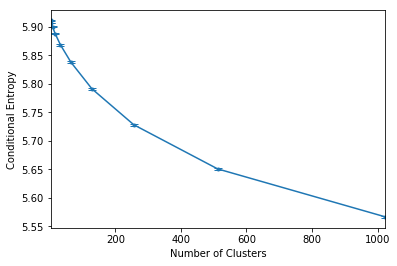

Number of Clusters,Mean Conditional Entropy,Std,Min,Max
2,5.91089,0.000353488,5.90964,5.91166
4,5.90664,0.000643125,5.90502,5.90831
8,5.89946,0.000901418,5.89704,5.90184
16,5.88777,0.00140333,5.88475,5.89189
32,5.86821,0.00143286,5.86493,5.87162
64,5.83775,0.00177347,5.83478,5.84254
128,5.79114,0.00181084,5.78793,5.79795
256,5.72796,0.00172552,5.7236,5.73443
512,5.65055,0.00197066,5.64721,5.65741
1024,5.56641,0.00180625,5.56226,5.57147


In [5]:
# Random flat encodings with different numbers of clusters
random = load_output('skipgram_flat_random.npz')
print('Iterations: {}'.format(random['nlls'].shape[1]))
# Plot entropy by number of clusters
bar(random['z_ks'], random['nlls'], axis=1)
plt.ylabel('Conditional Entropy')
plt.xlabel('Number of Clusters')
plt.xlim(2, 1024)
plt.show()
# Tabulate entropy by number of clusters
stats_table(random['z_ks'], random['nlls'], 
            'Number of Clusters',
           'Conditional Entropy', axis=1)

Iterations: 50


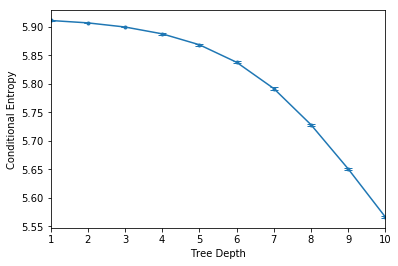

Tree Depth,Mean Conditional Entropy,Std,Min,Max
1,5.91088,0.000436061,5.90929,5.91155
2,5.90671,0.000568841,5.90549,5.90777
3,5.89945,0.000856081,5.89716,5.9021
4,5.8875,0.00120805,5.88419,5.8899
5,5.86835,0.00146809,5.86567,5.87183
6,5.83765,0.00168684,5.83463,5.84145
7,5.7916,0.00197922,5.78827,5.79791
8,5.72817,0.00191247,5.72409,5.73194
9,5.65073,0.00187701,5.64688,5.65457
10,5.56624,0.00149767,5.56344,5.56977


In [6]:
# Random tree encoding
tree_random = load_output('skipgram_tree_random.npz')
print('Iterations: {}'.format(tree_random['nlls'].shape[0]))
# Plot entropy by depth
bar(np.arange(1,11), tree_random['nlls'], axis=0)
plt.ylabel('Conditional Entropy')
plt.xlabel('Tree Depth')
plt.xlim(1,10)
plt.show()
# Tabulate entropy by depth
stats_table(np.arange(1,11), tree_random['nlls'], 
            'Tree Depth',
           'Conditional Entropy', axis=0)

## Baseline Skipgram Models

Train baseline skipgram models with different numbers of hidden units (`p=softmax(xW+b)`, `loss=expected(-log(p))`).

Performance with few units approaches the analytically calculated marginal entropy.

Performance with many units approaches the calculated conditional entropy.

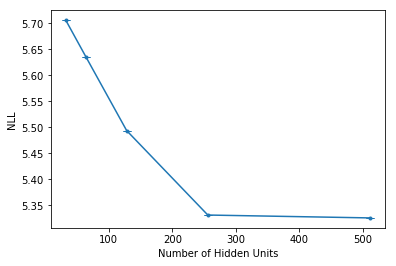

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.3256,3.69356e-07,5.3256,5.3256
256,5.33114,4.66935e-05,5.33108,5.33121
128,5.49359,9.51371e-05,5.49347,5.4937
64,5.63483,2.18327e-05,5.63479,5.63486
32,5.70584,2.80484e-06,5.70584,5.70585


In [7]:
# Vanialla baseline model
baseline = load_output('skipgram_baseline.npz')
# Plot NLL by number of hidden units
zks = baseline['z_ks']
bar(zks, baseline['nlls'], axis=1)
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.show()
# Tabulate NLL by number of hidden units
stats_table(zks, baseline['nlls'], 
            'Number of Hidden Units',
           'NLL', axis=1)

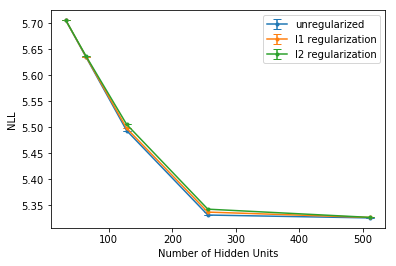

In [8]:
# Vanialla baseline model and regularization
baseline = load_output('skipgram_baseline.npz')
baselinel1 = load_output('skipgram_baseline-l1.npz')
baselinel2 = load_output('skipgram_baseline-l2.npz')
# Plot NLL by number of hidden units
zks = baseline['z_ks']
bar(zks, baseline['nlls'], 'unregularized')
bar(zks, baselinel1['nlls'], 'l1 regularization')
bar(zks, baselinel2['nlls'], 'l2 regularization')
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

## Binary Models

Experiments with models that cluster the vocabulary into two groups and attempt to minimize the conditional entropy of those clusters.

Proposed binary model outperformed all post-hoc clustering trials.

Average performance of post-hoc clustering underperformed random clustering in several situations.

### Proposed Binary Model

In [9]:
# Proposed binary model
binary = load_output('skipgram_binary.npz')
print('NLL: {}'.format(stats_string(binary['nlls'])))
print('Utilization: {}'.format(stats_string(binary['utilizations'])))


NLL: Mean 5.88556807427, Std 4.44760411065e-08, Min 5.88556799038, Max 5.88556810479, N 5
Utilization: Mean 2.0, Std 0.0, Min 2, Max 2, N 5


### Post-hoc Binary Clustering

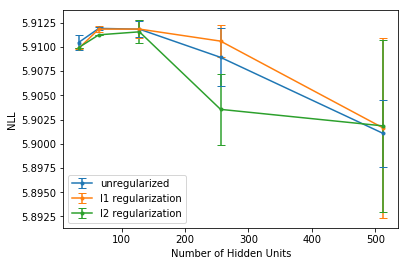

In [10]:
# GMM binary clustering
binary_gmm = load_output('skipgram_baseline_binary_gmm.npz')
# Plot NLL by baseline hidden units
bzks = binary_gmm['bzks']
bar(bzks, binary_gmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_gmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_gmm['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

In [11]:
stats_table(binary_gmm['bzks'], binary_gmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90108,0.0034548,5.89984,5.91303
256,5.90892,0.00300224,5.90512,5.91306
128,5.91182,0.000837471,5.91124,5.91306
64,5.9119,0.000165963,5.91185,5.91306
32,5.91045,0.000793652,5.9098,5.91305


In [12]:
stats_table(binary_gmm['bzks'], binary_gmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90165,0.00929419,5.89243,5.91303
256,5.91059,0.00166762,5.90925,5.91304
128,5.91183,0.000912794,5.91111,5.91306
64,5.91183,0.000322674,5.91172,5.91305
32,5.90983,4.58831e-05,5.90976,5.90989


In [13]:
stats_table(binary_gmm['bzks'], binary_gmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90185,0.00885674,5.89382,5.913
256,5.90355,0.00365792,5.90123,5.91299
128,5.91155,0.00118798,5.91051,5.91306
64,5.91124,4.18391e-06,5.91124,5.91125
32,5.90992,6.15765e-06,5.90991,5.90993


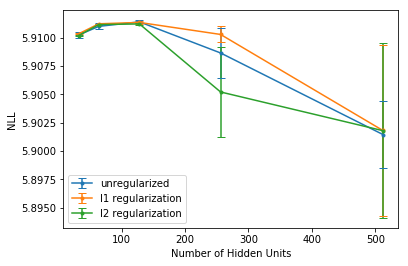

In [14]:
# GMM balanced binary clustering
binary_bgmm = load_output('skipgram_baseline_binary_bgmm.npz')
# Plot NLL by baseline hidden units
bzks = binary_bgmm['bzks']
bar(bzks, binary_bgmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_bgmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_bgmm['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

In [15]:
stats_table(binary_bgmm['bzks'], binary_gmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90108,0.0034548,5.89984,5.91303
256,5.90892,0.00300224,5.90512,5.91306
128,5.91182,0.000837471,5.91124,5.91306
64,5.9119,0.000165963,5.91185,5.91306
32,5.91045,0.000793652,5.9098,5.91305


In [16]:
stats_table(binary_bgmm['bzks'], binary_gmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90165,0.00929419,5.89243,5.91303
256,5.91059,0.00166762,5.90925,5.91304
128,5.91183,0.000912794,5.91111,5.91306
64,5.91183,0.000322674,5.91172,5.91305
32,5.90983,4.58831e-05,5.90976,5.90989


In [17]:
stats_table(binary_bgmm['bzks'], binary_gmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90185,0.00885674,5.89382,5.913
256,5.90355,0.00365792,5.90123,5.91299
128,5.91155,0.00118798,5.91051,5.91306
64,5.91124,4.18391e-06,5.91124,5.91125
32,5.90992,6.15765e-06,5.90991,5.90993


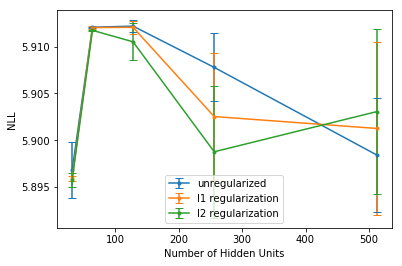

In [18]:
# Kmeans binary clustering
binary_km = load_output('skipgram_baseline_binary_kmeans.npz')
# Plot NLL by baseline hidden units
bzks = binary_km['bzks']
bar(bzks, binary_km['baseline'], 'unregularized', axis=(1,2))
bar(bzks, binary_km['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, binary_km['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

In [19]:
stats_table(binary_km['bzks'], binary_km['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.89844,0.0060863,5.89402,5.91306
256,5.90779,0.00364671,5.90311,5.91305
128,5.91221,0.000629088,5.91168,5.91306
64,5.91209,3.83019e-05,5.91204,5.91213
32,5.89682,0.00297384,5.89573,5.91305


In [20]:
stats_table(binary_km['bzks'], binary_km['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90126,0.0092474,5.89231,5.91301
256,5.90253,0.00676673,5.89532,5.91306
128,5.91208,0.000673067,5.91157,5.91306
64,5.91205,0.000137076,5.91199,5.91305
32,5.89591,0.000277967,5.8955,5.89623


In [21]:
stats_table(binary_km['bzks'], binary_km['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.90305,0.00879789,5.89387,5.913
256,5.89876,0.00707608,5.89448,5.91305
128,5.91053,0.00199767,5.90769,5.91306
64,5.91175,1.67035e-05,5.91173,5.91179
32,5.89578,0.000755487,5.894,5.89658


## Flat Models (k=1024)
Experiments with models that cluster the vocabulary into 1024 groups (`2**10`) and attempt to minimize the conditional entropy of the clusters.

Proposed model outperformed all post-hoc clustering trials.

Proposed model with regularization outperformed original model.

Average performance of post-hoc clustering underperformed random clustering in several situations.

### Proposed Clustering Models

In [23]:
# Flat model without regularization
flat = load_output('skipgram_flat.npz')
print("Flat NLL: {}".format(stats_string(flat['nlls'])))
print("Flat Utilization: {}".format(stats_string(flat['utilizations'])))

Flat NLL: Mean 5.5480435445, Std 0.000778813805342, Min 5.54713744241, Max 5.54945816655, N 5
Flat Utilization: Mean 809.4, Std 4.8, Min 804, Max 816, N 5


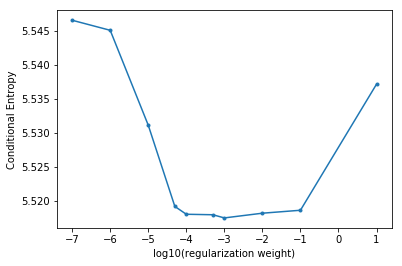

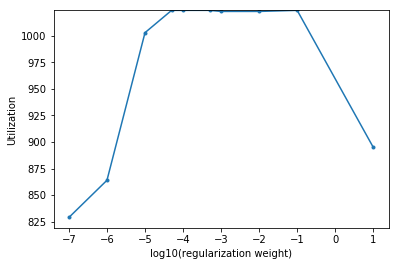

In [13]:
# Flat model with balance regularizer
flat_b = load_output('skipgram_flat-b.npz')
# plot NLL by regularization weight
x = np.log10(flat_b['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_b['nlls'], axis=1)
plt.plot(x, mean, markersize=3, marker='o')
plt.ylabel('Conditional Entropy')
plt.xlabel(xlabel)
plt.show()
meanu = np.mean(flat_b['utilizations'], axis=1)
plt.plot(x, meanu, markersize=3, marker='o')
plt.ylabel('Utilization')
plt.xlabel(xlabel)
plt.ylim(None, 1024)
plt.show()

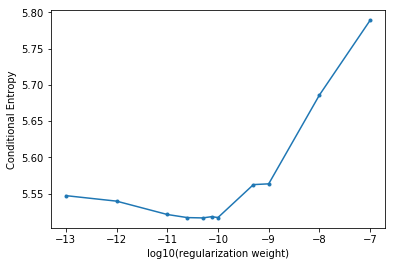

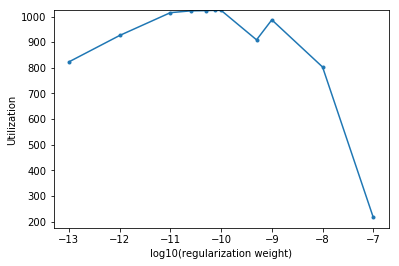

In [45]:
# Flat model with exclusive lasso regularizer
flat_el = load_output('skipgram_flat-el.npz')
# plot NLL by regularization weight
x = np.log10(flat_el['weights'])
xlabel = 'log10(regularization weight)'
mean = np.mean(flat_el['nlls'], axis=1)
plt.plot(x, mean, markersize=3, marker='o')
plt.ylabel('Conditional Entropy')
plt.xlabel(xlabel)
plt.show()
meanu = np.mean(flat_el['utilizations'], axis=1)
plt.plot(x, meanu, markersize=3, marker='o')
plt.ylabel('Utilization')
plt.xlabel(xlabel)
plt.ylim(None, 1024)
plt.show()

### Post-hoc clustering (k=1024)

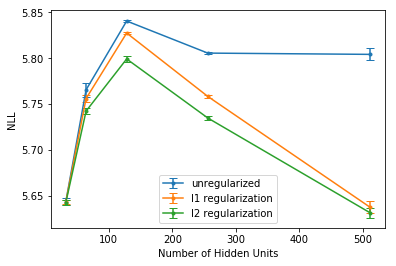

In [26]:
# GMM clustering
flat_gmm = load_output('skipgram_baseline_flat_gmm.npz')
# Plot NLL by baseline hidden units
bzks = flat_gmm['bzks']
bar(bzks, flat_gmm['baseline'], 'unregularized', axis=(1,2))
bar(bzks, flat_gmm['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, flat_gmm['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

In [27]:
stats_table(flat_gmm['bzks'], flat_gmm['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.8042,0.00666509,5.79462,5.81402
256,5.80559,0.00139121,5.80245,5.80807
128,5.84063,0.000841765,5.83908,5.8426
64,5.76551,0.00771248,5.74984,5.77836
32,5.6432,0.00363094,5.63785,5.64948


In [28]:
stats_table(flat_gmm['bzks'], flat_gmm['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.63722,0.00649483,5.62689,5.6479
256,5.75826,0.00141825,5.75554,5.76029
128,5.82751,0.00149464,5.82515,5.82915
64,5.75601,0.0034133,5.75085,5.76081
32,5.64303,0.00263519,5.6382,5.64757


In [29]:
stats_table(flat_gmm['bzks'], flat_gmm['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.63119,0.00556723,5.62113,5.63874
256,5.73471,0.00230246,5.73169,5.73922
128,5.79919,0.00287396,5.79418,5.80326
64,5.74227,0.00354311,5.73543,5.74859
32,5.64235,0.0028155,5.63846,5.64737


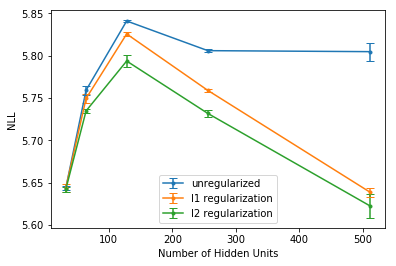

In [31]:
# Kmeans clustering
flat_km = load_output('skipgram_baseline_flat_kmeans.npz')
# Plot NLL by baseline hidden units
bzks = flat_km['bzks']
bar(bzks, flat_km['baseline'], 'unregularized', axis=(1,2))
bar(bzks, flat_km['l1'], 'l1 regularization', axis=(1,2))
bar(bzks, flat_km['l2'], 'l2 regularization', axis=(1,2))
plt.ylabel('NLL')
plt.xlabel('Number of Hidden Units')
plt.legend()
plt.show()

In [32]:
stats_table(flat_km['bzks'], flat_km['baseline'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.80479,0.010606,5.77793,5.81606
256,5.80597,0.00142725,5.80416,5.8094
128,5.84102,0.000866851,5.83856,5.84229
64,5.75925,0.0053002,5.75003,5.76769
32,5.64362,0.0027889,5.63676,5.6493


In [33]:
stats_table(flat_km['bzks'], flat_km['l1'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.6387,0.0051866,5.62924,5.64478
256,5.75903,0.00161966,5.75615,5.76232
128,5.82571,0.00225665,5.82227,5.83046
64,5.74954,0.00527283,5.74208,5.75966
32,5.64373,0.00478092,5.637,5.64934


In [34]:
stats_table(flat_km['bzks'], flat_km['l2'],
           'Number of Hidden Units',
           'NLL', axis=(1,2))

Number of Hidden Units,Mean NLL,Std,Min,Max
512,5.62251,0.0140955,5.59504,5.63322
256,5.73182,0.00436974,5.7233,5.73881
128,5.79372,0.00676037,5.7837,5.80117
64,5.73481,0.00214017,5.73118,5.7396
32,5.64221,0.00299156,5.63737,5.64804


## Tree Models
Experiments arranging vocabulary into a binary tree.

{'utilizations': (2L, 3L, 10L), 'betas': (2L,), 'nlls': (2L, 3L, 10L)}


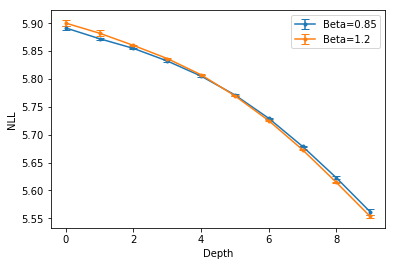

In [41]:
tree = load_output('skipgram_tree.npz')
print(data_shapes(tree))
x = np.arange(10)
bar(x, tree['nlls'][0,:,:], 'Beta={}'.format(tree['betas'][0]), axis=0)
bar(x, tree['nlls'][1,:,:], 'Beta={}'.format(tree['betas'][1]), axis=0)
plt.ylabel('NLL')
plt.xlabel('Depth')
plt.legend()
plt.show()

In [39]:
print('Beta: {}'.format(tree['betas'][0]))
stats_table(np.arange(10), tree['nlls'][0,:,:],
           'Depth',
           'NLL', axis=0)

Beta: 0.85


Depth,Mean NLL,Std,Min,Max
0,5.8914,0.00316443,5.88695,5.89403
1,5.87211,0.00161671,5.87076,5.87438
2,5.85477,0.00132591,5.85298,5.85616
3,5.8322,0.00108436,5.83078,5.83342
4,5.80512,0.0013193,5.80408,5.80698
5,5.77126,0.00136411,5.76942,5.77267
6,5.72942,0.00109841,5.72789,5.73043
7,5.67903,0.000376761,5.67863,5.67954
8,5.62271,0.00281838,5.6206,5.62669
9,5.56167,0.00516434,5.55763,5.56896


In [40]:
print('Beta: {}'.format(tree['betas'][1]))
stats_table(np.arange(10), tree['nlls'][1,:,:],
           'Depth',
           'NLL', axis=0)

Beta: 1.2


Depth,Mean NLL,Std,Min,Max
0,5.90012,0.00512324,5.89521,5.90719
1,5.88196,0.0052076,5.87645,5.88895
2,5.86014,0.00133224,5.85915,5.86202
3,5.83657,0.00108008,5.83505,5.83748
4,5.80746,0.000838969,5.80628,5.80806
5,5.76975,0.000994862,5.76844,5.77085
6,5.72525,0.000899602,5.72398,5.7259
7,5.67302,0.00131257,5.67121,5.67427
8,5.61448,0.00138258,5.61254,5.61564
9,5.55348,0.00272414,5.54962,5.55544
